<a href="https://colab.research.google.com/github/Mario-RJunior/olist-e-commerce/blob/master/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise Temporal

Nesta etapa do trabalho estaremos focados em estudar sobre a sazonalidade e as tendências das compras online e para isso faremos uma análise utilizando as séries temporais correspondentes. Assim, nosso primeiro passo é importar as bibliotecas a serem utilizadas e carregar os dados que precisaremos para tal análise.

### 1) Importando e carregando os dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime, date

In [2]:
! git clone https://github.com/Mario-RJunior/olist-e-commerce

fatal: destination path 'olist-e-commerce' already exists and is not an empty directory.


Inicialmente iremos selecionar as colunas que iremos utilizar e a seguir agrupá-las para gerar o dataframe.

In [3]:
# Selecionando as colunas para uso
orders_col = ['order_id', 'order_status', 'order_purchase_timestamp', 
              'order_approved_at', 'order_delivered_carrier_date', 
              'order_delivered_customer_date', 'order_estimated_delivery_date']
orders_items_col = ['order_id', 'shipping_limit_date', 'price']

In [4]:
# Carregando os datasets
orders = pd.read_csv('olist-e-commerce/datasets/olist_orders_dataset.csv', 
                     usecols=orders_col)
orders_items = pd.read_csv('olist-e-commerce/datasets/olist_order_items_dataset.csv', 
                           usecols=orders_items_col)

In [5]:
# Junção dos dataframes
df = pd.merge(right=orders_items,
             left=orders,
             on='order_id')

In [6]:
df.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-06 11:07:15,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-30 03:24:27,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-13 08:55:23,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-23 19:45:59,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-19 20:31:37,19.90


In [7]:
df.shape

(112650, 9)

- Verificando os tipos das variáveis.

In [8]:
# Tipo das variáveis
df.dtypes

order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
shipping_limit_date               object
price                            float64
dtype: object

Agora, como desejamos trabalhar com séries temporais devemos então converter as respectivas colunas para o formato *datetime*, uma vez que elas estão originalmente no formato *object*.

In [9]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

Uma vez convertidas para datetime iremos fazer mais um tratamento, sobretudo na coluna "order_purchase_timestamp". Primeiramente iremos pegar apenas a data (desconsiderando a hora da compra) para depois gerar uma nova data com o dia 1 em todas elas. O motivo para isso é agruparmos mais facilmente as datas por ano e mês.

***Importante***: Apesar de termos uma time series diária ela não é contínua, ou seja, há dias em que não houve compras e portanto tais dias não aparecem registrados. Desta forma faremos nossa análise contabilizando todas as compras mensalmente.

In [10]:
# Pegando apenas a data da coluna "order_purchase_timestamp"
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x: x.date())

# Editando a coluna "order_purchase_timestamp" para agrupar por ano e mês
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x: datetime(x.year, x.month, 1))

In [11]:
# Confirmando os tipos de dados
df.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
price                                   float64
dtype: object

In [12]:
# Verificando a existência de valores nulos
df.isnull().sum()

order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
shipping_limit_date                 0
price                               0
dtype: int64

In [13]:
# Verificando as datas da primeira e da última compra
print('Data mínima: {} \nData máxima: {}'.format(df['order_purchase_timestamp'].min(), 
                                                 df['order_purchase_timestamp'].max()))

Data mínima: 2016-09-01 00:00:00 
Data máxima: 2018-09-01 00:00:00


In [14]:
df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).count()['order_id']

order_purchase_timestamp  order_purchase_timestamp
2016                      9                              6
                          10                           363
                          12                             1
2017                      1                            955
                          2                           1951
                          3                           3000
                          4                           2684
                          5                           4136
                          6                           3583
                          7                           4519
                          8                           4910
                          9                           4831
                          10                          5322
                          11                          8665
                          12                          6308
2018                      1                           8208
     

Note que no mês de setembro de 2018 temos apenas 1 registro e portanto iremos desconsiderá-lo da nossa análise.

In [15]:
df.query('order_purchase_timestamp == "2018-09-01"')

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price
70511,54282e97f61c23b78330c15b154c867d,shipped,2018-09-01,2018-09-03 17:40:06,2018-09-04 15:25:00,NaT,2018-09-06,2018-09-05 17:30:54,145.0


In [16]:
df.drop(index=70511, inplace=True)

In [17]:
# Verificando novamente a data máxima
print('Data máxima: {}'.format(df['order_purchase_timestamp'].max()))

Data máxima: 2018-08-01 00:00:00


- Plotando os dados para a quantidade de produtos vendidos mensalmente

In [18]:
# Criando o dataframe da quantidade
df_group_quant = df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).count()['order_id']

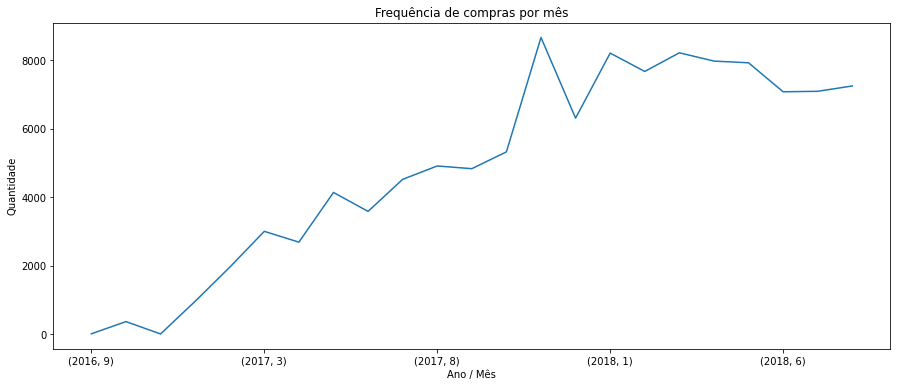

In [19]:
df_group_quant.plot(figsize=(15,6))
plt.title('Frequência de compras por mês')
plt.xlabel('Ano / Mês')
plt.ylabel('Quantidade')
plt.show()

- Plotando os dados para o total de dinheiro arrecadado pelas vendas mensalmente

In [20]:
df_group_price = df.groupby([df['order_purchase_timestamp'].dt.year,
           df['order_purchase_timestamp'].dt.month]).sum()['price']

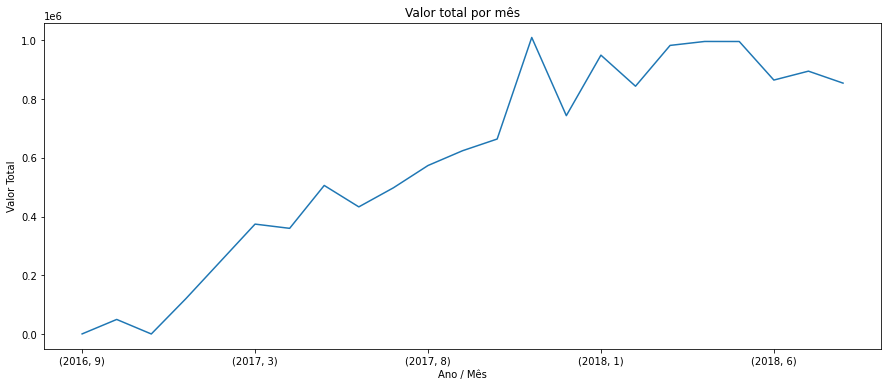

In [21]:
df_group_price.plot(figsize=(15,6))
plt.title('Valor total por mês')
plt.xlabel('Ano / Mês')
plt.ylabel('Valor Total')
plt.show()

- Criação do modelo usando o Prophet

Nesta etapa iremos utilizar a biblioteca fbprophet para gerar um modelo com o intuito de encontrar sazonalidade, tendência e fazer algumas previsões para compras nos meses futuros.

A seguir, precisaremos criar um dataframe apropriado para utilização do Prophet em ambos os casos.

In [23]:
# Criação do modelo
model = Prophet(yearly_seasonality=True)

- Criando os respectivos dataframes

1) Considerando a quantidade de vendas

In [24]:
# Criação do dataframe das quantidades
ts_quant = df.groupby('order_purchase_timestamp').count()['order_id'].reset_index()
ts_quant.rename(columns= {
    'order_purchase_timestamp': 'ds',
    'order_id': 'y'
    }, inplace=True)
ts_quant.head()

,ds,y
0,2016-09-01,6
1,2016-10-01,363
2,2016-12-01,1
3,2017-01-01,955
4,2017-02-01,1951


2) Considerando o preço total das vendas

In [25]:
# Criando o dataframe do valor total das vendas
ts_preco = df.groupby('order_purchase_timestamp').sum()['price'].reset_index()
ts_preco.rename(columns= {
    'order_purchase_timestamp': 'ds',
    'price': 'y'
    }, inplace=True)
ts_preco.head()

,ds,y
0,2016-09-01,267.36
1,2016-10-01,49507.66
2,2016-12-01,10.90
3,2017-01-01,120312.87
4,2017-02-01,247303.02
